# Macroprudential Policy and the Housing Market
This notebook solves and simulates the Heterogenous Agent Housing Market (HAH) model and produces the output contained in my Master's thesis. 

**Dependencies:**

The code structure builds upon the framework developed by Jeppe Druedahl & Co. in the [NumEconCopenhagen Project](https://github.com/NumEconCopenhagen)

Packages required for running the notebook are:
- [ConSav](https://pypi.org/project/ConSav/)
- [EconModel](https://pypi.org/project/EconModel/)
- [matplotlib](https://pypi.org/project/matplotlib/)
- [numpy](https://pypi.org/project/numpy/)
- [numba](https://pypi.org/project/numba/)
- [pandas](https://pypi.org/project/pandas/)

In [13]:
# imports
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd
nb.set_num_threads(4)

from HAHModel import HAHModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import data for equivalence scale and life cycle income profile

In [14]:
wd = '/Users/Christian/Dropbox/KU - Polit/KA/Thesis'
data = pd.read_excel(
    io=wd+'/equiscale.xlsx',
    sheet_name='output')

# interpolate income profile and slice
data['chi'] = data['chi'].interpolate(method='linear')
data = data.iloc[3:-1,:]

# extract arrays
n = data['n'].to_numpy(dtype='float')
chi = data['chi'].to_numpy(dtype='float')

## Baseline model

In [15]:
# initialise an instance of baseline model
model_baseline = HAHModelClass(
    name='baseline',
    par={
        'zeta':100,
        'chi':chi,
        #'n':n,
        'do_print':True
        })

model_baseline.precompile_numba() # solve model with very coarse grids --> speed gains
#model_baseline.save()

 t = 3 solved in 44.7 secs
 t = 2 solved in 49.1 secs
 t = 1 solved in 0.0 secs
 t = 0 solved in 0.0 secs
 total precomputation time  = 60.7 secs
 total stay-time  = 9.4 secs
 total ref-time   = 10.3 secs
 total buy-time   = 8.7 secs
 total rent-time   = 4.6 secs
 full model solved in = 93.8 secs
model simulated in 60.1 secs
numba precompiled in 157.3 secs


In [16]:
model_baseline.solve(do_assert=True)
model_baseline.simulate()

 last period bequest computed in 0.0 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 54 solved in 0.2 secs
 v_bar and q computed in 2.1 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 53 solved in 2.2 secs
 v_bar and q computed in 2.8 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 52 solved in 3.0 secs
 v_bar and q computed in 3.6 secs
 solved stayer problem in 0.2 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 51 solved in 3.8 secs
 v_bar and q computed in 4.2 secs
 solved stayer problem in 0.2 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t =

### Life Cycle Dynamics

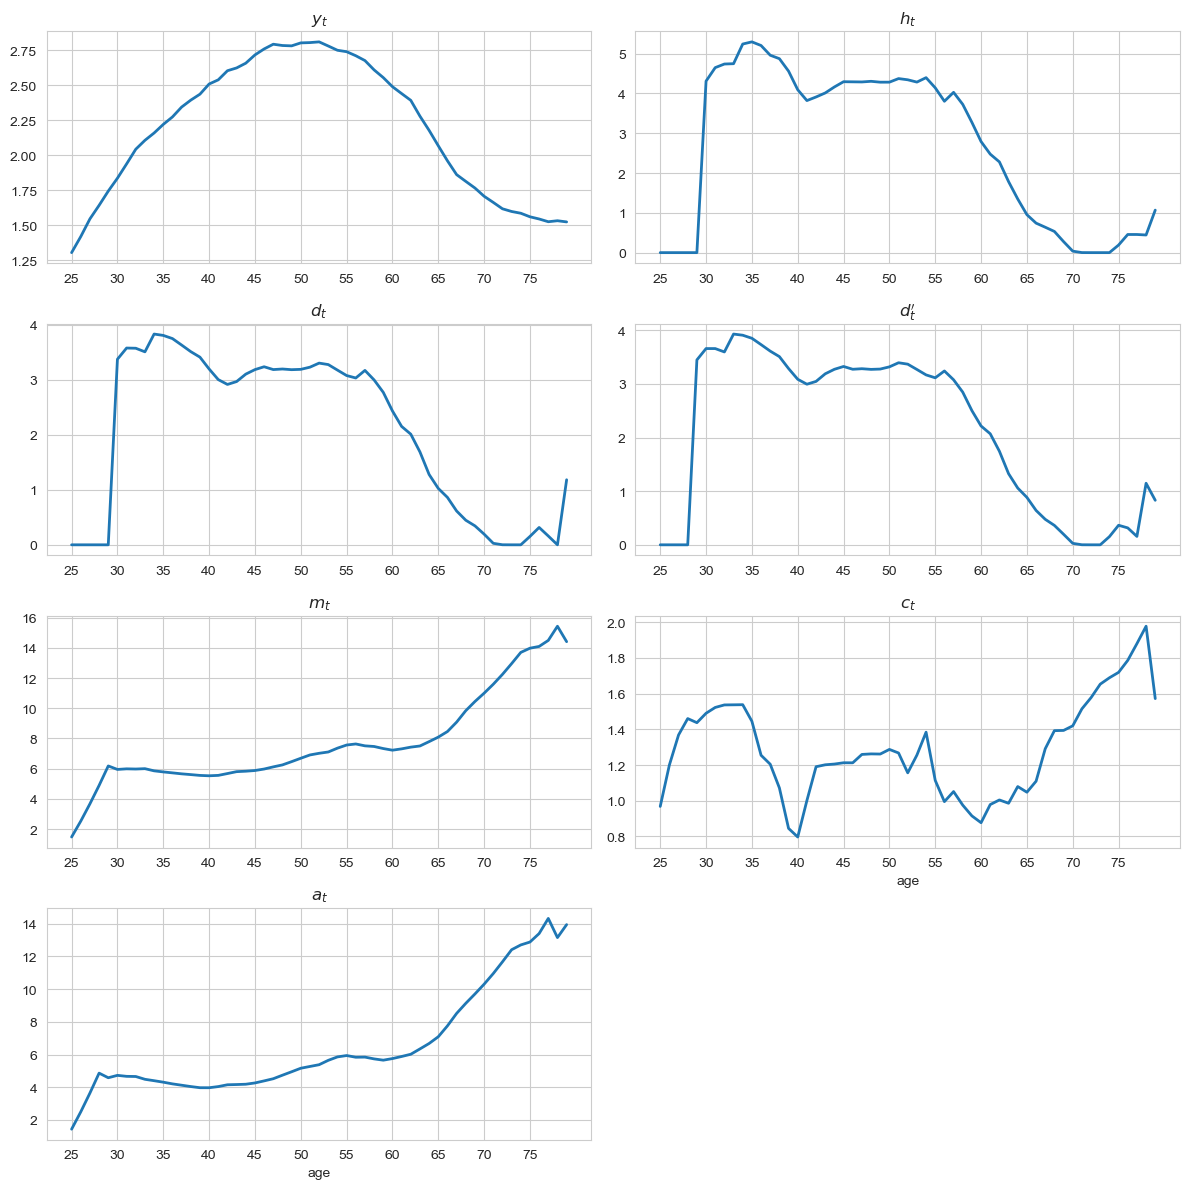

In [20]:
import figs

# average behaviour over the life cycle
figs.lifecycle(model=model_baseline)

### Test solving the household problem for a few periods

In [12]:
import HHproblems as hhp
from EconModel import jit

par = model_baseline.par

t = par.T-1
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

with jit(model_baseline) as model: 
    sol = model.sol
    par = model.par
    hhp.last_period_v_bar_q(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')
    t = t-1
    print(f'start solving t={t}')
    hhp.postdecision_compute_v_bar_q.py_func(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance fast is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy fast is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')


post decision is done
stay is done
refinance is done
buy is done
rent is done
start solving t=2
post decision is done
stay is done
refinance fast is done
buy fast is done
rent is done


In [ ]:
## check NaNs in relevant part of sol.inv_v_bar
#nan_mat_v = np.argwhere(np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]))
#print(f'size of q at t={t} is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_v.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_v}')
#
## check zero or negative entries in relevant part of sol.inv_v_bar
#zero_mat_v= np.argwhere(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
#print(f'size of c_endo at t={t} with Tda in 0,1,2 is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {zero_mat_v.shape[0]} zero or negative entries')
#print(f'the zero indices/negative are {zero_mat_v}')

########################################################################################################
#
## check for NaNs in relevant part of inv_v_bar
#nan_mat_inv_v_bar = np.argwhere(np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]))
#print(f'size of sol.inv_v_bar at t={t} is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_inv_v_bar.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_inv_v_bar}')
#
## check zero or negative entries in relevant part of sol.q
#zero_mat_inv_v_bar = np.argwhere(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
#print(f'size of sol.inv_v_bar at t={t} with Tda in 0,1,2 is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {zero_mat_inv_v_bar.shape[0]} zero or negative entries')
#print(f'the zero indices are {zero_mat_inv_v_bar}')

#######################################################################################################
#
## check for NaNs in relevant part of c_stay
#nan_mat_c_stay = np.argwhere(np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,1:-1]))
#print(f'size of sol.c_stay at t={t} is {sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_c_stay.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_c_stay}')

## check for zeros in relevant part of c_stay
#zero_mat_c_stay = np.argwhere(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] == 0)
#print(f'size of sol.c_stay at t={t} is {sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {zero_mat_c_stay.shape[0]} zero entries')
#print(f'the indices are {zero_mat_c_stay}')

### Testing utility functions, tax scheme and mortgage payment

In [16]:
import mt
import utility

with jit(model_baseline) as model_jit:
    par = model_jit.par
    
    # mortgage schedule
    annuity,pr_rem,interest,pr_pmt = mt.mpmt(10**6,1,20,0,par)

    # income and property tax
    tax_h = mt.property_tax(1.0,2.0,par)
    ytilde = mt.income_aftertax(2.2,0.8,3.5,0,par)

    # utility
    u_stay = utility.func(1,2,0,0,5,par)
    marg_u_stay = utility.marg_func(2,par,par.T-1)
    u_move = utility.func(1,2,1,0,5,par)
    u_rent = utility.func(1,2,1,1,5,par)

# print output
print(f'the full annuity payment is {round(annuity,2)}')
print(f'the remaining principal is {round(pr_rem,2)}')
print(f'the interest payment is {round(interest,2)}')
print(f'the principal payment is {round(pr_pmt,2)}')
print('--------------------------------------------')
print(f'the property tax is {round(tax_h,2)}')
print(f'the after tax income is {round(ytilde,2)}')
print('--------------------------------------------')
print(f'utility for a stayer is {round(u_stay,2)}')
print(f'marginal stay utility is {round(marg_u_stay,2)}')
print(f'utility for a mover is {round(u_move,2)}')
print(f'utility for a renter is {round(u_rent,2)}')


the full annuity payment is 67215.71
the remaining principal is 962784.29
the interest payment is 30000.0
the principal payment is 37215.71
--------------------------------------------
the property tax is 0.02
the after tax income is 1.57
--------------------------------------------
utility for a stayer is -3.17
marginal stay utility is 0.18
utility for a mover is -3.51
utility for a renter is -3.55


### Testing transition rules

In [34]:
import trans

# da periods
Tda_next = trans.Tda_plus_func(10)
print(Tda_next)

m_plus_net_stay = np.zeros(5)
m_plus = np.ones(5)

with jit(model_baseline) as model:
    par = model.par
   
    # mortgage balance
    d_plus = trans.d_plus_func(d=1.5,t=5,Td=20,Tda=0,par=par)
    for i in range(5):
        m_plus_net_stay[i] = trans.m_to_mnet_stay(m_plus=m_plus[i],h=4,par=par)

print(f'next period mortgage balance is {d_plus}') 
print(f'm_plus_net_stay is {m_plus_net_stay}')

# income states

9
next period mortgage balance is 1.4441764386047113
m_plus_net_stay is [0.9032 0.9032 0.9032 0.9032 0.9032]


### Sanity checks